In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import seaborn as sns

from showcase.models.mlp import MLP
import mode_connectivity.curves as curves
from mode_connectivity.net import CurveNet


 Define relevant functions

In [2]:
def features(x):
    return np.hstack([x[:, None] / 2.0, (x[:, None] / 2.0) ** 2])

def load_model(
    path,
    architecture,
    curve,
    num_bends,
    wd,
    fix_start,
    fix_end,
    num_classes: int,
    input_shape,
):
    curve = getattr(curves, curve)
    model = CurveNet(
        num_classes=num_classes,
        num_bends=num_bends,
        weight_decay=wd,
        curve=curve,
        curve_model=architecture.curve,
        fix_start=fix_start,
        fix_end=fix_end,
        architecture_kwargs=architecture.kwargs,
    )

    model.build(input_shape=input_shape)
    model.load_weights(filepath=path)
    model.compile()

    return model


def load_regression_data():
    data = np.load("../datasets/data.npy")
    x = data[:, 0]
    x_linspace = np.linspace(min(x), max(x), 100)
    f_lin = features(x_linspace)
    dataset_tensor = tf.constant(f_lin)

    return dataset_tensor, data, x_linspace


def plot_point_on_curve(point_on_curve, model, dataset_tensor, data, x_linspace):
    point_on_curve_tensor = tf.constant(point_on_curve, shape=(), dtype=tf.float32)
    model.point_on_curve.assign(point_on_curve_tensor)
    prediction = model(dataset_tensor, training=False).numpy()
    sns.set_style("darkgrid")
    blue = sns.color_palette()[0]
    red = sns.color_palette()[3]
    plt.figure(figsize=(9.0, 7.0))
    plt.plot(
        data[:, 0],
        data[:, 1],
        "o",
        color=red,
        alpha=0.7,
        markeredgewidth=1.0,
        markeredgecolor="k",
    )
    plt.plot(x_linspace, prediction, color=blue)
    plt.title("Prediction for regression data", fontsize=16)


def plot_points_on_curve(n_points_on_curve, model, dataset_tensor, data, x_linspace):
    sns.set_style("darkgrid")
    palette = sns.color_palette("colorblind")
    blue = sns.color_palette()[0]
    red = sns.color_palette()[3]
    plt.figure(figsize=(9.0, 7.0))
    plt.plot(
        data[:, 0],
        data[:, 1],
        "o",
        color=red,
        alpha=0.7,
        markeredgewidth=1.0,
        markeredgecolor="k",
    )
    plt.title("Predictions of curve for regression data", fontsize=16)

    points_on_curve = np.linspace(0.0, 1.0, n_points_on_curve)
    for i, point_on_curve in enumerate(points_on_curve):
        with tf.device("/cpu:0"):
            point_on_curve_tensor = tf.constant(
                point_on_curve, shape=(), dtype=tf.float32
            )
            model.point_on_curve.assign(point_on_curve_tensor)
        prediction = model(dataset_tensor, training=False).numpy()
        if i in (0.0, 1.0):
            plt.plot(x_linspace, prediction, color="g")
        else:
            plt.plot(x_linspace, prediction, color=blue)



In [3]:
path_model_init = "../results/Regression_MLP/checkpoints_curve/model-weights-epoch0"

path_model_trained = "../results/Regression_MLP/checkpoints_curve/model-weights-epoch100"

model_init = load_model(
    path=path_model_init,
    architecture=MLP,
    curve="Bezier",
    num_bends=5,
    wd=5e-4,
    fix_start=True,
    fix_end=True,
    num_classes=10,
    input_shape=(None, 2),
)

model_trained = load_model(
    path=path_model_trained,
    architecture=MLP,
    curve="Bezier",
    num_bends=5,
    wd=5e-4,
    fix_start=True,
    fix_end=True,
    num_classes=10,
    input_shape=(None, 2),
)


dataset_tensor, data, x_linspace = load_regression_data()


 Plot single curve

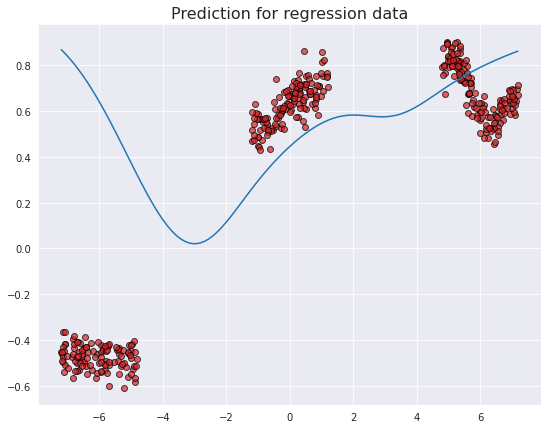

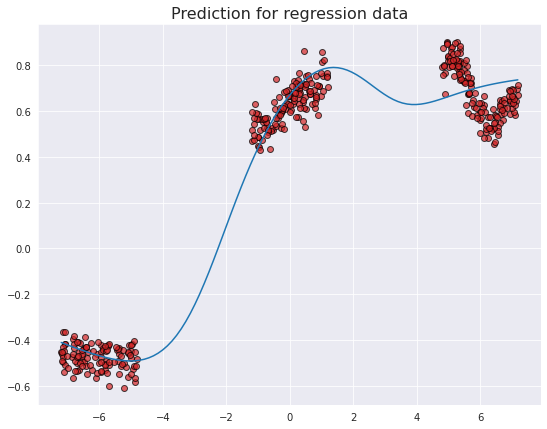

In [4]:
point_on_curve = 0.5

plot_point_on_curve(point_on_curve, model_init, dataset_tensor, data, x_linspace)

plot_point_on_curve(point_on_curve, model_trained, dataset_tensor, data, x_linspace)


 Plot multiple curves for points on curve

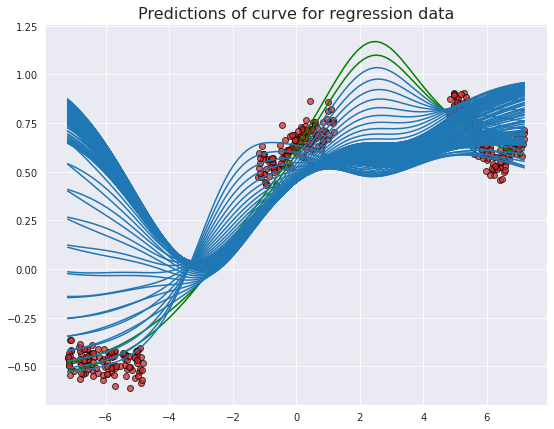

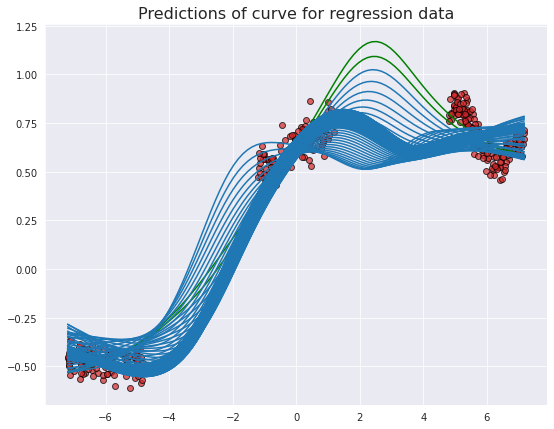

In [5]:
n_points_on_curve = 100

plot_points_on_curve(n_points_on_curve, model_init, dataset_tensor, data, x_linspace)

plot_points_on_curve(n_points_on_curve, model_trained, dataset_tensor, data, x_linspace)